In [1]:
import os

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import nivapy3 as nivapy
import calendar

# For mapping isource locations to vassdragsområder
# Connect to db
eng = nivapy.da.connect_postgis()

Connection successful.


# Notebook for summarising terrestrial inputs to the Oslofjord under different scenarios

Starting from the model input files, calculate total fluxes of DIN and TotalN to the Oslofjord from three sources:
1. River inputs
2. Direct WWTW inputs that are added to river inputs in a post-processing step by Phil
3. Direct WWTW inputs sthat are added directly to the fjord

1 & 2 are combined in a single river input netcdf file, 3 is in a separate 'internal source' netcdf file. Here, we take these netcdf model input files as starting point, then calculate monthly and annual fluxes per model river, real river and vassdragsområde and sum up over vassdragsområder. Do this for baseline and scenarios, to summarise the effect of different load reduction scenarios on total loads to the Oslofjord and to the vassdragsområder that make up the Oslofjord drainage basin.

Validation results against TEOTIL3:
- Remember not to compare % changes in 

# User input

In [2]:
# Version of processing (for file naming & reading correct inputs)
# v1: only included real rivers up to real river 20. Used in first draft of report
# v2: include all real rivers in of800 domain
# v3: 2025, include lots more parameters, and two scenarios
version = 3

# Model river numbers to include
# v2: River input scenario generated for model rivs 7-29 (incl.), but summarise over
# the full OF800 domain (model rivers 5 to 29, inclusive, i.e. include Sweden)
oslofjord_model_riv_nos = list(range(5, 30))  # Model river numbers

# Time period to summarise over
start_year = 2017
end_year = 2019

nc_folder = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/of800_v10ad_forcing_files'

nc_fname_dict = {'Baseline': 'of800_rivers_v9_2017_2019_RA4.nc',
                 'Scenario_A': 'of800_rivers_v9_2017_2019_RA4_v3_Scenario_A.nc',
                 'Scenario_B': 'of800_rivers_v9_2017_2019_RA4_v3_Scenario_B.nc',
                 'Pristine': 'of800_rivers_v9_2017_2019_v3_pristine.nc'}

nc_isource_fname_dict = {'Baseline': 'of800_v10ac_isource_2017_2019.nc',
                         'Scenario_A': 'of800_v10ac_isource_2017_2019_v3_Scenario_A.nc',
                         'Scenario_B': 'of800_v10ac_isource_2017_2019_v3_Scenario_B.nc'}

spm_bsl_fname = "of800_rivers_v9_2017_2019_SPM.nc"
spm_bsl_fpath = os.path.join(nc_folder, spm_bsl_fname)

# SPM scenario reduction factors (from NB 02, provided to PWA)
ss_f_red_dict = {'Scenario_A': 0.377, 'Scenario_B': 0.283, 'Pristine': 0.082}

out_folder_csvs = f"../output/csvs/v{version}"
out_folder_scenario_figs = f"../output/plots/v{version}/scenarios"
out_folder_baseline_figs = f"../output/plots/v{version}/baseline"

# Read or create mappings

In [3]:
# Mapping from model river number to real river number (index: model riv no, returns real no)
setup_fpath = r"../data/oslofjord_location_ids.csv"
river_nos_s = pd.read_csv(setup_fpath, index_col=0).squeeze('columns')
river_nos_s

model_river
1      1
2      1
3      2
4      3
5      4
6      5
7      6
8      7
9      7
10     7
11     7
12     7
13     7
14     8
15     9
16    10
17    11
18    12
19    13
20    14
21    15
22    17
23    18
24    19
25    20
26    20
27    21
28    22
29    23
30    24
31    25
32    26
33    27
34    28
35    29
36    30
37    31
38    32
39    33
40    34
41    34
42    35
43    36
44    37
45    38
46    39
Name: real_river, dtype: int64

In [4]:
# Mapping real river to vassdragsområde

# Work out corresponding real river numbers
min_val = min(oslofjord_model_riv_nos)
max_val = max(oslofjord_model_riv_nos)
oslofjord_real_riv_nos = river_nos_s.loc[min_val:max_val].tolist()
# Drop non-unique
oslofjord_real_riv_nos = list(set(oslofjord_real_riv_nos))
print(oslofjord_real_riv_nos)

real_riv_metadata = r"../data/real_river_metadata.csv"
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})

# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_real_riv_nos)]

# Fill NaNs in the Vassdragsområde columns with 'Sweden'
river_meta_df.loc[river_meta_df.index < 6, 'Vassom'] = river_meta_df.loc[river_meta_df.index < 6, 'Vassom'].fillna('Sweden')

river_meta_df['Vassom_name'] = river_meta_df.apply(lambda row: 'Sweden' if row['Vassom'] == 'Sweden' else row['river_name'], axis=1)

river_meta_df

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23]


,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment,Vassom_name
real_river,,,,,,,,,,,,,
4.0,Strömsån,NaN,NaN,NaN,NaN,Strömsån,467.0,NaN,NaN,NaN,NaN,NaN,Strömsån
5.0,Enningdalsälv,NaN,NaN,NaN,NaN,Enningdalsälv,810.0,NaN,NaN,NaN,NaN,NaN,Enningdalsälv
6.0,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN,Tista
7.0,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...,Glomma
8.0,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN,Mosseelva
9.0,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN,Hølenelva
10.0,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN,Årungen
11.0,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN,Akerselva
12.0,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN,Lysakerelva


In [5]:
# Mapping vassdragsområde number to area
vass_areas_s = river_meta_df[['Vassom', 'Vassom_area_land']].copy()
vass_areas_s.set_index('Vassom', inplace=True)
vass_areas_s.drop_duplicates(inplace=True)
vass_areas_s = vass_areas_s.squeeze()

In [6]:
# Make mapping from Vassdragsområde number to name
vass_num_to_name = river_meta_df[['Vassom', 'Vassom_name']].copy()
vass_num_to_name.set_index('Vassom', inplace=True)
vass_num_to_name.drop_duplicates(inplace=True)
vass_num_to_name = vass_num_to_name.squeeze()

In [7]:
# Mapping from real river number to river name
river_names_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_names.csv'
river_names_s = pd.read_csv(river_names_fpath, index_col=0).squeeze('columns')
river_names_s.head()

real_river
1         Göta älv
2           Bäveån
3     Örekilsälven
4         Strömsån
5    Enningdalsälv
Name: river_name, dtype: object

In [8]:
# Vassdragsområde to real river
vass_to_realriv_dict = river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
vass_to_realriv_dict

{'Strömsån': 4.0,
 'Enningdalsälv': 5.0,
 '001.': 6.0,
 '002.': 7.0,
 '003.': 8.0,
 '004.': 9.0,
 '005.': 10.0,
 '006.': 11.0,
 '007.': 12.0,
 '008.': 13.0,
 '009.': 14.0,
 '010.': 15.0,
 '011.': 17.0,
 '012.': 18.0,
 '013.': 19.0,
 '014.': 20.0,
 '015.': 21.0,
 '016.': 22.0,
 '017.': 23.0}

In [9]:
# isource to Vassdragsområde
wwtp_isource_location_fpath = r'../data/of800_v10ac_isource_2017_2019_ps_list_2025-11.xlsx'

# Get vassdragsområder
gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)

# Read point co-ords
isource_vassom_map_df = pd.read_excel(wwtp_isource_location_fpath)

# Assign vassom number to points
isource_vassom_map_df = nivapy.spatial.identify_point_in_polygon(
    isource_vassom_map_df,
    gdf,
    pt_col="isource number",
    poly_col="vassdragsomradenr",
    lat_col="isource_lat",
    lon_col="isource_lon",
)

# Reformat vassdragsområde integer to match string format used elsewhere
isource_vassom_map_df = isource_vassom_map_df.rename({'vassdragsomradenr': 'Vassdragsområde'}, axis=1)
isource_vassom_map_df['Vassdragsområde'] = isource_vassom_map_df['Vassdragsområde'].apply(lambda x: (str(x)).zfill(3) + '.')

# Convert to series with iSource integer index
isource_vassom_map_df = isource_vassom_map_df.set_index('isource number')

isource_vassom_map_df

# v1 & v2:
# wwtp_isource_map_fpath = r'../data/Flux_Martini_Rivers_sewage_with_mapping_and_fractions_v2.xlsx'
# isource_vassom_map_df = pd.read_excel(wwtp_isource_map_fpath, sheet_name='vassområde_link', index_col=0)
# # Reformat vassdragsområde integer to match string format used elsewhere
# isource_vassom_map_df['Vassdragsområde'] = isource_vassom_map_df['Vassdragsområde'].apply(lambda x: (str(x)).zfill(3) + '.')
# isource_vassom_map_df

,isource_name,isource_Xposition,isource_Eposition,isource_lat,isource_lon,Vassdragsområde
isource number,,,,,,
1,Bekkelaget renseanlegg med tilførselstuneller ...,188,127,59.881414,10.758925,006.
2,Kambo avløpsanlegg,136,106,59.475943,10.683073,003.
3,Fuglevik avløpsanlegg,124,98,59.384194,10.644209,003.
4,Lilleng Brukssenter renseanlegg,109,80,59.225405,10.823791,002.
5,Hestevold renseanlegg,118,86,59.315492,10.778186,003.
...,...,...,...,...,...,...
72,Heidelberg Materials Miljø AS avd. Brevik,51,134,59.065332,9.696061,016.
73,INOVYN Norge avd. Rafnes,52,144,59.101550,9.586910,016.
74,Ineos Rafnes,52,143,59.096132,9.593346,016.


# Read in and process river netcdf files

## Define functions

In [10]:
def riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos, species_dict):
    """
    Read in OF800 river input netcdf file. Convert to dataframe of concentrations (mg N, P or C/l)
    & river discharge (m3/s) for real rivers. Output dataframe.
    """

    # Make list of variables to save from the ds
    # To do this, flatten all variable lists in species_dict into a single list, then remove duplicates
    riv_var_li = list(set(var for sublist in species_dict.values() for var in sublist))
    riv_var_li = riv_var_li + ['river_transport']

    # List of teotil3 variables
    t3_vars = list(species_dict.keys())

    # Start processing
    ds = xr.open_dataset(nc_fpath)

    # Check whether all vars in riv_var_li are present in the ds
    # (won't be, as have SPM processing separate to nutrient processing)
    missing_vars = [var for var in riv_var_li if var not in ds.variables]
    if missing_vars:
        print(f"Warning: The following variables are not found in the dataset and will be excluded: {missing_vars}")

    # Filter to only include present variables
    present_vars = [var for var in riv_var_li if var in ds.variables]
    ds = ds[present_vars]

    df = ds.to_dataframe()
    ds.close()
    df = df.reset_index()  # Drop multiindex

    # Remove depth info
    if 's_rho' in df.columns:
        df = df.drop(columns=['s_rho'])
        df = df.drop_duplicates()  # There were around 40 s_rho values for each (river_time, river)

    df = df.sort_values(by=['river', 'river_time'])

    # Take the absolute of discharge values (assume they give direction)
    df['river_transport'] = df['river_transport'].abs()

    # Select just model river numbers of interest
    df = df[df['river'].isin(oslofjord_model_riv_nos)].copy()

    # Add real river number & drop the model number
    df['real_river'] = df['river'].map(river_nos_s)
    df = df.drop(columns=['river'])

    # Truncate to time period of interest
    df['year'] = df['river_time'].dt.year
    df = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year)]
    df = df.drop('year', axis=1)

    # Calculate TEOTIL3 variables from OF800 variables
    for t3_var in t3_vars:
        df[t3_var] = df[species_dict[t3_var]].sum(axis=1)

    # Drop all the fractions apart from the teotil3 ones
    keep_cols = t3_vars + ['real_river', 'river_time', 'river_transport']
    df = df[keep_cols]

    to_float64_vars = ['river_transport'] + t3_vars
    # SPM data was stored as float 32. Convert all to float 64
    df[to_float64_vars] = df[to_float64_vars].astype('float64')

    # Sum or average over model rivers to get real river data

    # groupby object used multiple times below
    grouped = df.groupby(['real_river', 'river_time'])

    # # Check if all discharge values in each group are the same. If not, will have to
    # # flow-weight the concentrations when calculating means. Result: all good
    # is_constant = grouped['river_transport'].nunique() <= 1

    # if not is_constant.all():
    #     print(f"Discharge values are not the same for all real river model groupings")
    #     # Find the first group where river_transport is not constant
    #     non_constant_groups = is_constant[is_constant == False]
    #     first_non_constant_group = non_constant_groups.index[0]
    #     last_non_constant_group = non_constant_groups.index[-1]
    #     Print out the values of the first group where river_transport is not constant
    #     print("Values of the first and last groups where river_transport is not constant:")
    #     print(grouped.get_group(first_non_constant_group))
    #     print(grouped.get_group(last_non_constant_group))
    #     print("Number of non-constant groups: %s" % len(non_constant_groups))

    # else:
    #     print("Discharge values constant between model river groups")

    # For QC. Manually checked the summing & averaging working ok. It is.
    # (If redoing this, remember the chem units here are mmol/m3, whereas conc_df is mg/l)
    # print(df.loc[(df['real_river'] == 7) & (df['river_time'] == '2016-01-01 12:00')])

    # Sum discharge
    sum_df = grouped.agg({'river_transport': 'sum'})

    # Mean of the chem columns within each river
    mean_df = grouped[t3_vars].mean()

    # Join the sums and means to one df
    conc_df = pd.concat([sum_df, mean_df], axis=1)
    conc_df = conc_df.reset_index()

    # Convert concentration units to mg/l across all variables
    for var in t3_vars:
        if var in ['SS', 'SPM']:
            continue  # Skip, as units are already mg/l
        if var not in ['TOC', 'DOC']:
            # P and N variables have units mMoles/m3
            conc_df[var] = conc_df[var] * Mr_dict[var] * 0.001
        else:
            # (DOC is in mg C/m3, so just convert to mg C/l)
            conc_df[var] = conc_df[var] * 0.001

    # Rename cols
    rename_dict = {'river_time': 'date', 'river_transport': 'Q'}
    conc_df = conc_df.rename(rename_dict, axis=1)

    return conc_df


def calc_daily_flux(conc_df, out_folder, run_type, t3_vars):
    """
    Units kg/day for chem vars, m3/day for Q
    Assumes units in conc_df are mg/l
    """
    load_df = conc_df[['real_river', 'date']].copy()
    # Ensure the 'date' column is in datetime format
    load_df['date'] = pd.to_datetime(load_df['date'])
    load_df['Q'] = conc_df['Q'] * 86400  # from m3/s to m3/day

    for var in t3_vars:
        # Load in kg/day
        chem_kgperm3 = conc_df[var] * 1000 * 10**-6
        load_df[var] = load_df['Q'] * chem_kgperm3

    # To csv
    fpath = os.path.join(out_folder, f'daily_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    load_df.to_csv(fpath)

    return load_df


def calc_month_annual_flux(daily_load_df, freq, out_folder, run_type, t3_vars):
    """
    Input:
        freq: 'monthly' for monthly, 'annual' for annual
        run_type: string, for file naming. E.g. 'baseline'
    Output: df, units Q: 10^6 m3/month or year; chem cols: T/month or year
    """
    freq_dict = {'monthly': 'ME',
                 'annual': 'YE'}

    agg_load_df = daily_load_df.set_index(['real_river', 'date']).groupby('real_river').resample(freq_dict[freq], level='date').sum()
    agg_load_df.reset_index(inplace=True)

    # Convert units: chem species from kg to 10^3 kg/month or year (i.e. tonnes)
    for var in t3_vars:
        agg_load_df[var] = agg_load_df[var] / 10**3

    # Convert Q from m3 to 10^6 m3
    agg_load_df['Q'] = agg_load_df['Q'] / 10**6

    if freq == 'annual':
        agg_load_df['year'] = pd.to_datetime(agg_load_df['date']).dt.year
        agg_load_df = agg_load_df.drop('date', axis=1)

    # Write to csv
    fpath = os.path.join(out_folder, f'{freq}_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    agg_load_df.to_csv(fpath)

    return agg_load_df


def mean_annual_flux(annual_load_df, out_folder, run_type):
    """
    Average over years to get overall mean annual flux per real river
    Inputs run_type: format string, for filenaming
    Output: df, index: real_river, cols: Q (10^6 m3/yr), t3_vars (T/yr)
    """
    # Drop 'year'
    yr_mean_df = annual_load_df.drop('year', axis=1)
    yr_mean_df = yr_mean_df.groupby('real_river').mean()

    # Write to csv
    fpath = os.path.join(out_folder, f'mean_annual_riv_flux_{start_year}-{end_year}_{run_type}.csv')
    yr_mean_df.to_csv(fpath)

    return yr_mean_df

## Processing

In [11]:
# Setup

# Molar masses for converting from molar to mass concentrations
# (C variables already have units mg/m3)
Mr_dict = {"TotN": 14.007, "DIN":14.007, "TotP": 30.974, "TDP": 30.974}

# Dictionary for mapping from teotil3 variable names to OF800 variable names
riv_species_dict = {
        "TotN": ["river_N3_n", "river_N4_n", "river_R123_n", "river_R4_n", "river_R6_n", "river_R8_n"],  # (NO3, NH4, DON, PON)
        "DIN": ["river_N3_n", "river_N4_n"],  # NO3, NH4
        # "TotP": [ "river_N1_p", "river_R123_p", "river_R4_p", "river_R6_p", "river_R8_p"],  # (SRP, DOP, POP). Exclude, Phil thinks too uncertain
        "TDP": ["river_N1_p", "river_R123_p"],  # SRP, DOP
        "TOC": ["river_R123_c", "river_R4_c", "river_R6_c", "river_R8_c"],  # DOC, POC
    }

# Separate dictionary for renamning SPM
ss_dict = {"SS": ["river_SPM"]}

# Aggregated variables aren't provided in the internal sources files, so for DOx species, have to sum over the 2 colour x 3 lability = 6 fractions
isource_species_dict = {
    "DIN": ["isource_N3_n", "isource_N4_n"],
    "TotN": [
        "isource_N3_n",
        "isource_N4_n",  # DIN
        "isource_NR1_n",
        "isource_CR1_n",
        "isource_NR2_n",
        "isource_CR2_n",
        "isource_NR3_n",
        "isource_CR3_n",  # DON
        "isource_R4_n",
        "isource_R6_n",
        "isource_R8_n",  # PON
    ],
    "TOC": [
        "isource_NR1_c",
        "isource_CR1_c",
        "isource_NR2_c",
        "isource_CR2_c",
        "isource_NR3_c",
        "isource_CR3_c",  # DOC
        "isource_R4_c",
        "isource_R6_c",
        "isource_R8_c",  # POC
    ],
    "TDP": [
        "isource_N1_p",  # SRP
        "isource_NR1_p",
        "isource_CR1_p",
        "isource_NR2_p",
        "isource_CR2_p",
        "isource_NR3_p",
        "isource_CR3_p",  # DOP
        # "isource_R4_p",  # POP
        # "isource_R6_p",  # POP
        # "isource_R8_p",  # POP
    ],
}

# Complete var list to be used
t3_var_li = ['TotN', 'DIN', 'SS', 'TOC', 'TDP']

In [12]:
# # Testing with just one scenario
# nc_fpath = os.path.join(nc_folder, nc_fname_dict['Baseline'])
# ds = xr.open_dataset(nc_fpath)
# # ds = ds[riv_var_li]
# ds.close()

# scenario = 'Baseline'
# conc_df = riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos, riv_species_dict)
# daily_load_df = calc_daily_flux(conc_df, out_folder_csvs, scenario)
# monthly_load_df = calc_month_annual_flux(daily_load_df, 'monthly', out_folder_csvs, scenario)
# annual_load_df = calc_month_annual_flux(daily_load_df, 'annual', out_folder_csvs, scenario)
# mean_annual_load_df = mean_annual_flux(annual_load_df, out_folder_csvs, scenario)

# annual_load_df.head()

**Comment:** Real river 20 (Aulielva) is split into two model rivers. The two model rivers have different discharge but the same TOTN and DIN concentrations. So it is ok to calculate the mean conc of the real river group without weighting by discharge, as the mean is the same as the individual model river values.

Overall, the number of non-constant groups should be equivalent to the number of years of data * 365 days per year. i.e. it's only river 20 this applies to. For all other real rivers that are split into multiple model rivers, the discharge is split evenly between model rivers.

In [13]:
# # Test for SPM
# ss_conc_df = riv_ds_to_df(spm_bsl_fpath, oslofjord_model_riv_nos, ss_dict)
# daily_ss_load_df = calc_daily_flux(ss_conc_df, out_folder_csvs, "bsl_SS", ['SS'])
# monthly_ss_load_df = calc_month_annual_flux(daily_ss_load_df, 'monthly', out_folder_csvs, "bsl_SS", ['SS'])
# annual_ss_load_df = calc_month_annual_flux(daily_ss_load_df, 'annual', out_folder_csvs, "bsl_SS", ['SS'])
# mean_annual_ss_load_df = mean_annual_flux(annual_ss_load_df, out_folder_csvs, "bsl_SS")  # 1000 T/yr

# mean_annual_ss_load_df.head()

In [14]:
# Process for all scenarios
daily_conc_dict = {}
daily_load_dict = {}
monthly_rivflux_dict = {}
annual_rivflux_dict = {}
mean_annual_rivflux_dict = {}

add_ss_data = True

# List of teotil3 variables of interest for all except SS
t3_vars = list(riv_species_dict.keys())

for scenario in nc_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_fname_dict[scenario])
    conc_df = riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos, riv_species_dict)

    if add_ss_data:
        if scenario == 'Baseline':
            ss_conc_df = riv_ds_to_df(spm_bsl_fpath, oslofjord_model_riv_nos, ss_dict)
            t3_vars += ['SS']
        else:
            ss_conc_df = daily_conc_dict['Baseline'][['real_river', 'date', 'SS']].copy()
            ss_conc_df['SS'] = ss_conc_df['SS'] * ss_f_red_dict[scenario]
        conc_df = conc_df.merge(ss_conc_df[['real_river', 'date', 'SS']], on=['real_river', 'date'])

    daily_load_df = calc_daily_flux(conc_df, out_folder_csvs, scenario, t3_vars)
    monthly_load_df = calc_month_annual_flux(daily_load_df, 'monthly', out_folder_csvs, scenario, t3_vars)
    annual_load_df = calc_month_annual_flux(daily_load_df, 'annual', out_folder_csvs, scenario, t3_vars)
    mean_annual_load_df = mean_annual_flux(annual_load_df, out_folder_csvs, scenario)

    # Add to dictionaries
    daily_conc_dict[scenario] = conc_df
    daily_load_dict[scenario] = daily_load_df
    monthly_rivflux_dict[scenario] = monthly_load_df
    annual_rivflux_dict[scenario] = annual_load_df
    mean_annual_rivflux_dict[scenario] = mean_annual_load_df

    # print(annual_load_df.head())
    print(mean_annual_load_df.round(2))
    print('\n')

Baseline
                   Q      TotN      DIN     TDP        TOC         SS
real_river                                                           
4              30.45     30.33    14.91    0.94     280.85      50.65
5             457.33    247.65   111.67    2.84    4261.03     760.89
6            1149.99   1254.55   789.34   26.61   10719.25    3446.96
7           23673.14  14970.76  9905.39  259.29  111023.13  170864.10
8             583.12    736.18   455.45   11.14    4816.96    1990.60
9             120.99    389.75   270.16   11.17     999.44    5073.60
10             60.03    229.70   142.60    2.76     386.83     623.54
11            185.74     79.36    42.56    2.19     835.84    1335.72
12            155.05     89.71    34.33    2.00    1227.81    1192.16
13            178.75    156.74   100.22    1.87    1050.23     656.88
14            443.93    741.65   483.65   16.75    2870.95    4822.03
15             92.61     78.74    68.21    3.01     492.36     366.79
17         

# Read in direct sewage inputs

Calculate the total wastewater treatment plant and any industrial loads that are included in OF800 as direct inputs to the fjord (the iSources netcdf file).

In [15]:
def isource_to_df(wwtp_fpath, isource_species_dict, t3_vars):
    """
    Input: filepath to ERSEM internal sources netcdf
    Output: Dataframe of monthly fluxes (units T/month)
    """

    isource_var_li = list(set(var for sublist in isource_species_dict.values() for var in sublist))

    wwtp_ds = xr.open_dataset(wwtp_fpath)
    wwtp_ds = wwtp_ds[isource_var_li]

    # Sum over the 's_rho' dimension
    wwtp_ds = wwtp_ds.sum(dim='s_rho')

    wwtp_df = wwtp_ds.to_dataframe()
    wwtp_df = wwtp_df.reset_index()  # Drop multiindex
    wwtp_ds.close()

    # Rename date column & truncate to time period of interest
    wwtp_df['isource_time'] = pd.to_datetime(wwtp_df['isource_time'])
    wwtp_df = wwtp_df.rename(columns={'isource_time': 'date'})
    wwtp_df['year'] = wwtp_df['date'].dt.year
    wwtp_df = wwtp_df.loc[(wwtp_df['year'] >= start_year) & (wwtp_df['year'] <= end_year)]
    wwtp_df = wwtp_df.drop('year', axis=1)

    print('Number of WWTPs: %s ' % len(wwtp_df['isource'].drop_duplicates()))

    # Calculate TEOTIL3 variables from iSource variables
    for t3_var in t3_vars:
        wwtp_df[t3_var] = wwtp_df[isource_species_dict[t3_var]].sum(axis=1)

    # Drop all columns which are not of interest
    cols_to_keep = ['isource', 'date'] + t3_vars
    wwtp_df = wwtp_df[cols_to_keep]

    # Convert flux units from mmol/s to 10^3 kg/month (tonnes/month)
    # N.B. To do: vectorize more...
    wwtp_df['days_in_month'] = wwtp_df['date'].dt.to_period('M').apply(lambda p: calendar.monthrange(p.year, p.month)[1])
    seconds_per_day = 86400
    factor = seconds_per_day * 1e-9  # grams/s → tonnes/d

    for var in t3_vars:
        if var in ['TOC', 'DOC']:
            wwtp_df[var] = wwtp_df[var] * factor * wwtp_df['days_in_month']
        else:
            wwtp_df[var] = wwtp_df[var] * Mr_dict[var] * factor * wwtp_df['days_in_month']

    # Drop days in month col
    wwtp_df = wwtp_df[cols_to_keep]

    return wwtp_df


def calculate_average_annual_sum(monthly_df, start_year, end_year):
    """
    Input: df with columns 'isource' and 'date', plus data
    Output: Fluxes, mean over start_year to end_year. Units T/yr
    """

    df = monthly_df.copy()

    # Add year col, and select only years within the user-specified range
    df['year'] = df['date'].dt.year
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()

    # Calculate annual sums
    df_numeric = df.drop(columns=['isource', 'year', 'date'])
    df_annual = df.groupby(['isource', 'year'])[df_numeric.columns].sum().reset_index()

    # Average the annual sums to get a single value per isource
    annual_mean_df = df_annual.groupby('isource').mean()
    # Drop 'year' column
    annual_mean_df = annual_mean_df.drop('year', axis=1)

    return annual_mean_df


def sum_over_vassom(input_df, time_col=[]):
    """
    Sum up multiple iSource inputs per vassdragsområde
    Input:
        input_df: dataframe, column or index=iSource id
        time_col: list of column names in input_df to base grouping on. E.g.
                  ['date']
    Output: dataframe, index=Vassdragsområde (format '00x.') if time_col==[], 
            otherwise, same cols as input df
            Units: T/yr
    """
    df = input_df.copy()

    # Add Vassdragsområde to the dataframe
    # Flexible, can cope with isource id being col or index

    if 'isource' in df.columns:
        df['Vassom'] = df['isource'].map(isource_vassom_map_df['Vassdragsområde'])
        missing_sources = df.loc[df['Vassom'].isna(), 'isource']
    else:
        df['Vassom'] = df.index.map(isource_vassom_map_df['Vassdragsområde'])
        # Use index values directly
        missing_sources = df.index[df['Vassom'].isna()]

    # Print warning if any missing
    if len(missing_sources) > 0:
        print(f"Warning: {len(missing_sources)} isource values were not found in the mapping:")

    # Drop rows where Vassom == NaN (further SW than we are considering here,
    # but double-check by looking at print statement if there are NaNs)
    df = df.dropna(subset=['Vassom'])

    grouping_cols = ['Vassom'] + time_col
    df = df[grouping_cols + t3_vars].groupby(grouping_cols).sum()

    # If no time col, keep the index as Vassom. Otherwise, reset it
    if time_col != []:
        df = df.reset_index()

    return df



In [16]:
# Testing
isource_var_li = list(set(var for sublist in isource_species_dict.values() for var in sublist))

# List of teotil3 variables of interest for all except SS
t3_vars = list(riv_species_dict.keys())

scenario = 'Baseline'
nc_fpath = os.path.join(nc_folder, nc_isource_fname_dict[scenario])
# wwtp_ds = xr.open_dataset(nc_fpath)
# wwtp_ds = wwtp_ds[isource_var_li]

# # Sum over the 's_rho' dimension
# wwtp_ds = wwtp_ds.sum(dim='s_rho')

# wwtp_ds
wwtp_isource_df = isource_to_df(nc_fpath, isource_species_dict, t3_vars)
wwtp_isource_df

Number of WWTPs: 76 


,isource,date,TotN,DIN,TDP,TOC
76,1.0,2017-01-15,36.362164,23.584961,0.412094,35.633266
77,2.0,2017-01-15,6.874759,4.936686,0.015720,5.911193
78,3.0,2017-01-15,14.338191,10.296156,0.047850,17.916060
79,4.0,2017-01-15,0.016732,0.015059,0.000017,0.006924
80,5.0,2017-01-15,1.872355,1.344251,0.005780,1.564781
...,...,...,...,...,...,...
2807,72.0,2019-12-15,0.000000,0.000000,0.000000,0.005860
2808,73.0,2019-12-15,0.000000,0.000000,0.000000,0.449288
2809,74.0,2019-12-15,0.025310,0.002548,0.013586,0.153811
2810,75.0,2019-12-15,0.000000,0.000000,0.000000,0.050110


In [17]:
monthly_isource_dict = {}
mean_annual_isource_dict = {}

# Process
for scenario in nc_isource_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_isource_fname_dict[scenario])
    wwtp_isource_df = isource_to_df(nc_fpath, isource_species_dict, t3_vars)  # cols isource, date, t3_vars
    isource_monthly_vassom_df = sum_over_vassom(wwtp_isource_df, ['date'])  #Cols Vassom, date, t3_vars

    # Only calculate average for WWTW over period when have good data for
    isource_av_yr_df = calculate_average_annual_sum(wwtp_isource_df, 2016, 2018)
    isource_av_yr_vassom_df = sum_over_vassom(isource_av_yr_df)

    # SPM is not included in WWTW at the moment. Add a zero so can sum with river inputs later
    isource_monthly_vassom_df['SS'] = 0
    isource_av_yr_vassom_df['SS'] = 0

    # Add to dictionaries
    monthly_isource_dict[scenario] = isource_monthly_vassom_df
    mean_annual_isource_dict[scenario] = isource_av_yr_vassom_df

    print(isource_monthly_vassom_df.head())
    print(isource_av_yr_vassom_df)
    # print(wwtp_isource_df.head())
    # print(isource_av_yr_df)
    print('\n')

Baseline
Number of WWTPs: 76 
  Vassom       date      TotN       DIN       TDP       TOC  SS
0   002. 2017-01-15  0.016732  0.015059  0.000017  0.006924   0
1   002. 2017-02-15  0.015113  0.013601  0.000015  0.006254   0
2   002. 2017-03-15  0.016732  0.015059  0.000017  0.006924   0
3   002. 2017-04-15  0.016192  0.014573  0.000016  0.006701   0
4   002. 2017-05-15  0.016732  0.015059  0.000017  0.006924   0
               TotN         DIN        TDP          TOC  SS
Vassom                                                     
002.       0.197004    0.177304   0.000195     0.081530   0
003.     282.611547  202.942242   0.862350   311.553555   0
004.     158.071900  113.525425   0.411089   134.503255   0
005.     104.737253   78.111202   1.164943   119.819516   0
006.     409.554794  265.612630   4.792936   421.394178   0
007.      65.506827   45.279748   5.633092   130.948914   0
009.    1227.244816  991.992924  16.058774  1591.362805   0
010.      14.350307   10.527247   0.030073    

In [18]:
# Make pristine isource dfs & add to dicts
isource_monthly_pristine_df = monthly_isource_dict['Baseline'].copy()
isource_annualav_pristine_df = mean_annual_isource_dict['Baseline'].copy()

# Columns to keep unchanged
keep_cols = ['Vassom', 'date']

# Set all other columns to 0
for col in isource_monthly_pristine_df.columns:
    if col not in keep_cols:
        isource_monthly_pristine_df[col] = 0
        isource_annualav_pristine_df[col] = 0

# Add to dicts
monthly_isource_dict['Pristine'] = isource_monthly_pristine_df
mean_annual_isource_dict['Pristine'] = isource_annualav_pristine_df

# Add river and direct WWTW inputs together

## Annual

In [19]:
# Annual averages
tot_annual_av_dict = {}
tot_nog_annual_av_dict = {}  # Dropping 2 swedish rivers
riv_wwtp_annual_av_dict = {}  # key:scenario, keeps info on separate contributions from rivs vs direct
tot_of_dict = {}  # Summed up over Oslofjord
tot_of_nog_dict = {}
tot_of_riv_vs_wwtp_dict = {}  # key:scenario, sum of inputs from rivs vs isources

for scenario in nc_fname_dict.keys():
    # Get river data
    riv_vassom_df = mean_annual_rivflux_dict[scenario].copy()

    # Sum river data over Vassdragsområde & reindex
    riv_vassom_df['Vassom'] = riv_vassom_df.index.map(river_meta_df['Vassom'])
    # Drop rows where Vassom == NaN (further SW than we are considering here)
    # riv_vassom_df = riv_vassom_df.dropna(subset=['Vassom'])
    riv_vassom_df = riv_vassom_df.groupby(['Vassom']).sum()

    # Get direct WWTW input data
    wwtp_df = mean_annual_isource_dict[scenario].copy()

    # Join the data
    # Add suffixes to the columns of each dataframe
    tmp_riv_df = riv_vassom_df.copy()
    tmp_riv_df.columns = [str(col) + '_riv' for col in riv_vassom_df.columns]
    tmp_wwtp_df = wwtp_df.copy()
    tmp_wwtp_df.columns = [str(col) + '_wwtw' for col in wwtp_df.columns]

    # Concatenate
    concat_df = pd.concat([tmp_riv_df, tmp_wwtp_df], axis=1)

    # Replace NaNs in the wwtw columns with 0 (i.e. no direct inputs in that vassom)
    concat_df = concat_df.fillna(0)

    # Save concat_df for source apportionment later
    riv_wwtp_annual_av_dict[scenario] = concat_df

    # Sum up over whole Oslofjord to look at % input from rivs vs direct WWTWs
    tot_of_concat_s = concat_df.sum()
    tot_of_riv_vs_wwtp_dict[scenario] = tot_of_concat_s
    # tot_of_concat_s['f_tn_wwtw'] = tot_of_concat_s['TOTN_wwtw'] / tot_of_concat_s['TOTN_riv']
    # tot_of_concat_s['f_din_wwtw'] = tot_of_concat_s['DIN_wwtw'] / tot_of_concat_s['DIN_riv']

    # Sum up river & direct WWTW inputs per vassdragsområde
    sum_df = concat_df[['Q_riv']].copy()
    sum_df.columns = ['Q']
    for var in t3_var_li:
        sum_df[var] = concat_df[f'{var}_riv'] + concat_df[f'{var}_wwtw']

    # For now don't have SPM WWTW data, so just add river inputs
    sum_df['SS'] = concat_df['SS_riv']

    tot_annual_av_dict[scenario] = sum_df

    # For comparison with Teotil3?
    # But in Teotil3 the changes in a Norwegian WWTP affect 001 I think in the scenarios...
    nog_sum_df = sum_df.loc['001.':'017.']

    tot_nog_annual_av_dict[scenario] = nog_sum_df
    fpath = os.path.join(out_folder_csvs, "vassom_total_inputs", f"nog_total_of800_inputs_per_vassom_{scenario}.csv")
    nog_sum_df.to_csv(fpath)

    # Sum up combined total inputs over whole Oslofjord domain
    tot_of_s = sum_df.sum()  # series, index values Q, t3 variables
    tot_of_dict[scenario] = tot_of_s

    # Same just for vassdragsområder 1 to 17
    tot_nog_of_s = nog_sum_df.sum()
    tot_of_nog_dict[scenario] = tot_nog_of_s

In [20]:
# Quick look at the output

tot_annual_av_dict['Baseline'].round(2)

,Q,TotN,DIN,SS,TOC,TDP
Vassom,,,,,,
001.,1149.99,1254.55,789.34,3446.96,10719.25,26.61
002.,23673.14,14970.96,9905.56,170864.10,111023.21,259.29
003.,583.12,1018.79,658.39,1990.60,5128.51,12.00
004.,120.99,547.82,383.69,5073.60,1133.94,11.58
005.,60.03,334.44,220.71,623.54,506.65,3.93
006.,185.74,488.92,308.18,1335.72,1257.23,6.99
007.,155.05,155.22,79.61,1192.16,1358.76,7.63
008.,178.75,156.74,100.22,656.88,1050.23,1.87
009.,443.93,1968.89,1475.65,4822.03,4462.31,32.81


In [21]:
tot_annual_av_dict['Scenario_A'].round(2)

,Q,TotN,DIN,SS,TOC,TDP
Vassom,,,,,,
001.,1149.99,1147.30,708.91,1299.51,10660.92,24.87
002.,23673.14,13366.31,8623.13,64415.77,108883.43,240.27
003.,583.12,807.42,506.00,750.45,4879.84,10.83
004.,120.99,414.55,287.45,1912.75,984.35,9.85
005.,60.03,308.49,201.62,235.08,456.72,3.45
006.,185.74,408.04,255.57,503.57,1203.03,6.97
007.,155.05,154.73,79.25,449.44,1357.38,7.58
008.,178.75,154.88,98.68,247.64,1040.71,1.80
009.,443.93,1406.85,992.72,1817.90,3198.76,31.59


A few points:
- In v1 & v2 there used to be a reduction in Sweden under the scenarios, because of one point source input from a Norwegian plant which was assumed to discharge into model river 6 (real river 5, Enningdalsalv). Otherwise no changes to agricultural river inputs on the swedish side.
- This seems to have been fixed in phase 3 (2025) which makes it simpler.

### Summary tables

In [22]:
# Whole Oslofjord fluxes

tot_of_df = pd.DataFrame(tot_of_dict)

# # Make 25, 50, 75 and 100% DIN reduction scenarios
# for pc in [25, 50, 75, 100]:
#     pc_factor = 1 - (pc/100)
#     tot_of_df[f'{pc}_DIN'] = tot_of_df['Baseline']
#     tot_of_df.loc['DIN', f'{pc}_DIN'] = tot_of_df.loc['DIN', 'Baseline'] * pc_factor
#     TN_reduction = tot_of_df.loc['DIN', 'Baseline'] - tot_of_df.loc['DIN', f'{pc}_DIN']
#     tot_of_df.loc['TotN', f'{pc}_DIN'] = tot_of_df.loc['TotN', 'Baseline'] - TN_reduction

tot_of_df = tot_of_df.round(1).transpose()
fpath = os.path.join(out_folder_csvs, 'of_totals', 'whole_oslofjord_input_scenarios_mean-tonnes-per-yr_v2.csv')
tot_of_df.to_csv(fpath)
tot_of_df

,Q,TotN,DIN,SS,TOC,TDP
Baseline,54761.8,36300.0,24596.8,277013.1,246677.0,531.3
Scenario_A,54761.8,31784.3,21001.8,104434.0,238811.8,495.1
Scenario_B,54761.8,27002.2,17090.9,78394.7,237605.8,371.2
Pristine,54761.8,10704.9,4013.9,22715.1,220039.0,95.7


**Comment:**
If comparing this with TEOTIL3 inputs to the whole Oslofjord, be aware that this also includes inputs from the two Swedish rivers (Enningdalsalv and Stromsån).

In [23]:
# Whole Oslofjord fluxes, but just Norwegian rivers for comparison to TEOTIL3

tot_of_nog_df = pd.DataFrame(tot_of_nog_dict)

tot_of_nog_df = tot_of_nog_df.round(1).transpose()
fpath = os.path.join(out_folder_csvs, 'of_totals', 'Norwegian_only_oslofjord_input_scenarios_mean-tonnes-per-yr_v2.csv')
tot_of_nog_df.to_csv(fpath)
tot_of_nog_df

,Q,TotN,DIN,SS,TOC,TDP
Baseline,54274.0,36022.0,24470.2,276201.6,242135.1,527.5
Scenario_A,54274.0,31506.3,20875.2,104128.0,234270.0,491.4
Scenario_B,54274.0,26724.2,16964.3,78165.1,233063.9,367.4
Pristine,54274.0,10430.5,3890.5,22648.5,215511.1,91.9


**Note: still not quite the same as the values Phil worked out independently. Very similar though.**

E.g.:
* TotN: I have 80 tonnes more under baseline, 12 tonnes more under ScenA and Scen B. Potential Bsl error of 0.2%
* DIN: I have 67 tonnes more under baseline, 3 & 4 tonnes less under Scens A & B. Potential Bsl error of 0.3%
* TOC: I have 131 tonnes less under baseline, only 11 and 14 under Scens A & B. Bsl error of 0.05%

i.e. fine to ignore. But would be nice to figure out why. Because the diff is so much larger under baseline than Scen A, I suspect it's a sewage issue as Scen A only really has sewage measures that affect DIN.

In [24]:
tot_by_source_df = pd.DataFrame(tot_of_riv_vs_wwtp_dict)

tot_by_source_df = tot_by_source_df.round(1).transpose()

for var in t3_var_li:
    riv = tot_by_source_df[f'{var}_riv']
    total = riv + tot_by_source_df[f'{var}_wwtw']
    tot_by_source_df[f'f_rivs_{var}'] = riv / total

fpath = os.path.join(out_folder_csvs, 'of_totals', 'Oslofjord_total_inputs_per_scenario_split_by_riv-vs-isource.csv')
tot_by_source_df.to_csv(fpath)

tot_by_source_df

,Q_riv,TotN_riv,DIN_riv,TDP_riv,TOC_riv,SS_riv,TotN_wwtw,DIN_wwtw,TDP_wwtw,TOC_wwtw,SS_wwtw,f_rivs_TotN,f_rivs_DIN,f_rivs_SS,f_rivs_TOC,f_rivs_TDP
Baseline,54761.8,31593.0,20827.4,493.4,242216.8,277013.1,4707.0,3769.3,38.0,4460.2,0.0,0.870331,0.846756,1.0,0.981919,0.928491
Scenario_A,54761.8,29288.4,18991.0,457.2,236877.2,104434.0,2495.9,2010.9,38.0,1934.7,0.0,0.921474,0.904252,1.0,0.991899,0.923263
Scenario_B,54761.8,25016.4,15466.6,339.8,235867.1,78394.7,1985.8,1624.3,31.4,1738.7,0.0,0.926458,0.904961,1.0,0.992682,0.915409
Pristine,54761.8,10704.9,4013.9,95.7,220039.0,22715.1,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.0,1.000000,1.000000


In [25]:
# To do: maybe work out aerial fluxes, to highlight most polluting rivers vs just those that are big?
# Code not working at the moment. Think I need Sweden1 and Sweden2 in the Vassom column, plus would like
# areas for the two

# areal_flux_df = tot_annual_av_dict['baseline'].copy()
# river_meta_df.set_index('Vassom', inplace=True)
# areal_flux_df['Area_km2'] = areal_flux_df.index.map(river_meta_df['Vassom_area_land'])
# areal_flux_df

In [26]:
# Annual % reduction per vassom and scenario

annual_reduction_pc_dict = {}  # key: scenario
for scenario in list(nc_fname_dict.keys()):
    if scenario != 'Baseline':
        annual_reduction_pc_df = 100 * (1 - tot_annual_av_dict[scenario] / tot_annual_av_dict['Baseline'])
        annual_reduction_pc_dict[scenario] = annual_reduction_pc_df

        fpath = os.path.join(out_folder_csvs, 'vassom_total_inputs', f'{scenario}_percent_reduction_per_vassom.csv')
        tot_by_source_df.to_csv(fpath)


In [27]:
annual_reduction_pc_dict['Scenario_A'].round(1)

,Q,TotN,DIN,SS,TOC,TDP
Vassom,,,,,,
001.,0.0,8.5,10.2,62.3,0.5,6.6
002.,0.0,10.7,12.9,62.3,1.9,7.3
003.,0.0,20.7,23.1,62.3,4.8,9.7
004.,0.0,24.3,25.1,62.3,13.2,14.9
005.,0.0,7.8,8.6,62.3,9.9,12.1
006.,0.0,16.5,17.1,62.3,4.3,0.2
007.,0.0,0.3,0.5,62.3,0.1,0.6
008.,0.0,1.2,1.5,62.3,0.9,3.7
009.,0.0,28.5,32.7,62.3,28.3,3.7


In [28]:
annual_reduction_pc_dict['Scenario_B'].round(1)

,Q,TotN,DIN,SS,TOC,TDP
Vassom,,,,,,
001.,0.0,25.3,31.2,71.7,0.6,21.4
002.,0.0,25.2,30.8,71.7,2.3,35.7
003.,0.0,36.7,41.3,71.7,5.0,36.0
004.,0.0,41.5,43.3,71.7,13.5,40.9
005.,0.0,31.5,33.0,71.7,10.8,40.1
006.,0.0,35.4,36.5,71.7,7.5,22.3
007.,0.0,23.8,32.3,71.7,4.9,39.8
008.,0.0,9.5,12.3,71.7,1.0,13.9
009.,0.0,42.2,47.6,71.7,28.6,11.1


In [29]:
# Dataframe for summarising key things:
# Baseline and scenario loads, percent reductions, load reductions

for var in t3_var_li:
    annual_av_res_df = tot_annual_av_dict['Baseline'][[var]].copy()
    annual_av_res_df.columns = ['Baseline_T-per-yr' for col in annual_av_res_df.columns]

    for scenario in list(nc_fname_dict.keys()):
        if scenario != 'Baseline':

            annual_av_res_df[f'{scenario}_T-per-yr'] = tot_annual_av_dict[scenario][var].copy()
            s = 100 * (1 - annual_av_res_df[f'{scenario}_T-per-yr'] / annual_av_res_df[f'Baseline_T-per-yr'])
            annual_av_res_df[f'{scenario}_%_reduction'] = s.round(3)

            # Tonnes removed
            annual_av_res_df[f'{scenario}_reduction_T-per-yr'] = annual_av_res_df[f'Baseline_T-per-yr'] - annual_av_res_df[f'{scenario}_T-per-yr']

    annual_av_res_df = annual_av_res_df.round(2)

    # Add vassdragsområde name and area
    annual_av_res_df['Vassom_name'] = annual_av_res_df.index.map(vass_num_to_name)
    annual_av_res_df['Area_km2'] = annual_av_res_df.index.map(vass_areas_s)

    fpath = os.path.join(out_folder_csvs, 'vassom_total_inputs', f'vassom_scenarios_results_summary_{var}.csv')
    annual_av_res_df.to_csv(fpath)

annual_av_res_df.tail()

,Baseline_T-per-yr,Scenario_A_T-per-yr,Scenario_A_%_reduction,Scenario_A_reduction_T-per-yr,Scenario_B_T-per-yr,Scenario_B_%_reduction,Scenario_B_reduction_T-per-yr,Pristine_T-per-yr,Pristine_%_reduction,Pristine_reduction_T-per-yr,Vassom_name,Area_km2
Vassom,,,,,,,,,,,,
015.,26.88,25.32,5.81,1.56,21.08,21.58,5.80,6.66,75.23,20.22,Numedalslågen,6275.0
016.,27.35,26.53,3.00,0.82,22.68,17.10,4.68,7.94,70.98,19.41,Skienselva,11279.0
017.,6.73,6.73,0.10,0.01,5.94,11.83,0.80,3.17,52.97,3.57,Kammerfosselva,1580.0
Enningdalsälv,2.84,2.84,0.00,0.00,2.84,0.00,0.00,2.81,0.97,0.03,Enningdalsälv,810.0
Strömsån,0.94,0.94,0.00,0.00,0.94,0.00,0.00,0.94,-0.00,-0.00,Strömsån,467.0


In [30]:
riv_wwtp_annual_av_dict['Scenario_A'].round()

,Q_riv,TotN_riv,DIN_riv,TDP_riv,TOC_riv,SS_riv,TotN_wwtw,DIN_wwtw,TDP_wwtw,TOC_wwtw,SS_wwtw
Vassom,,,,,,,,,,,
001.,1150.0,1147.0,709.0,25.0,10661.0,1300.0,0.0,0.0,0.0,0.0,0.0
002.,23673.0,13366.0,8623.0,240.0,108883.0,64416.0,0.0,0.0,0.0,0.0,0.0
003.,583.0,726.0,448.0,10.0,4794.0,750.0,82.0,58.0,1.0,86.0,0.0
004.,121.0,380.0,263.0,9.0,950.0,1913.0,35.0,25.0,0.0,35.0,0.0
005.,60.0,224.0,139.0,2.0,383.0,235.0,84.0,62.0,1.0,74.0,0.0
006.,186.0,79.0,42.0,2.0,836.0,504.0,329.0,213.0,5.0,367.0,0.0
007.,155.0,89.0,34.0,2.0,1226.0,449.0,66.0,45.0,6.0,131.0,0.0
008.,179.0,155.0,99.0,2.0,1041.0,248.0,0.0,0.0,0.0,0.0,0.0
009.,444.0,722.0,469.0,16.0,2610.0,1818.0,684.0,524.0,16.0,589.0,0.0


In [31]:
# Quick look at where the reductions are happening for the scenarios - in the river inputs or the isource inputs

(riv_wwtp_annual_av_dict['Baseline'] - riv_wwtp_annual_av_dict['Scenario_A']).round(0)

,Q_riv,TotN_riv,DIN_riv,TDP_riv,TOC_riv,SS_riv,TotN_wwtw,DIN_wwtw,TDP_wwtw,TOC_wwtw,SS_wwtw
Vassom,,,,,,,,,,,
001.,0.0,107.0,80.0,2.0,58.0,2147.0,0.0,0.0,0.0,0.0,0.0
002.,0.0,1605.0,1282.0,19.0,2140.0,106448.0,0.0,0.0,0.0,0.0,0.0
003.,0.0,11.0,8.0,1.0,23.0,1240.0,201.0,145.0,0.0,226.0,0.0
004.,0.0,10.0,8.0,2.0,50.0,3161.0,123.0,89.0,0.0,100.0,0.0
005.,0.0,5.0,3.0,0.0,4.0,388.0,21.0,16.0,0.0,46.0,0.0
006.,0.0,0.0,0.0,0.0,-0.0,832.0,81.0,52.0,0.0,54.0,0.0
007.,0.0,0.0,0.0,0.0,1.0,743.0,0.0,0.0,0.0,0.0,0.0
008.,0.0,2.0,2.0,0.0,10.0,409.0,0.0,0.0,0.0,0.0,0.0
009.,0.0,19.0,15.0,1.0,261.0,3004.0,543.0,468.0,0.0,1003.0,0.0


## Monthly

In [32]:
# Timeseries of monthly totals
tot_month_dict = {}  # key: scenario

for scenario in nc_fname_dict.keys():

    # Get river data
    riv_month_vassom_df = monthly_rivflux_dict[scenario].copy()

    # Sum river data over Vassdragsområde & drop real_riv column
    riv_month_vassom_df['Vassom'] = riv_month_vassom_df['real_river'].map(river_meta_df['Vassom'])
    riv_month_vassom_df.drop(['real_river'], axis=1, inplace=True)
    # Drop rows where Vassom == NaN (further SW than we are considering here)
    # riv_vassom_df = riv_vassom_df.dropna(subset=['Vassom'])
    riv_month_vassom_df = riv_month_vassom_df.groupby(['Vassom', 'date']).sum().reset_index()
    # Set date to be 15th of month, to match wwtw data
    riv_month_vassom_df['date'] = riv_month_vassom_df['date'].apply(lambda dt: dt.replace(day=15))

    # Get direct WWTW input data
    wwtp_month_df = monthly_isource_dict[scenario].copy()
    wwtp_month_df['Q'] = 0

    # Join
    join_month_df = pd.merge(riv_month_vassom_df, wwtp_month_df, on=['Vassom', 'date'], how='left', suffixes=('_riv', '_wwtw'))

    # WWTW has NaNs for Vassområde where there are no inputs. Fill with 0
    join_month_df = join_month_df.fillna(0)

    # Sum
    tot_month_df = join_month_df[['Vassom', 'date']].copy()
    for var in t3_var_li + ['Q']:
        tot_month_df[var] = join_month_df[f'{var}_riv'] + join_month_df[f'{var}_wwtw']

    # Reformat Vassdragsområde column
    # tot_month_df['Vassdragsområde'] = [int(val.strip('.')) if val.strip('.').isdigit() else val for val in tot_month_df['Vassom']]
    # tot_month_df.drop('Vassom', axis=1, inplace=True)

    tot_month_dict[scenario] = tot_month_df

In [33]:
riv_month_vassom_df.head()

,Vassom,date,Q,TotN,DIN,TDP,TOC,SS
0,001.,2017-01-15,99.212929,31.630341,12.477111,0.170880,786.117624,32.480849
1,001.,2017-02-15,33.406915,11.047370,4.361811,0.056905,264.621793,12.134457
2,001.,2017-03-15,117.177181,38.134815,15.047562,0.204504,943.747357,34.633349
3,001.,2017-04-15,73.487007,22.994746,9.025276,0.120669,623.718569,22.662481
4,001.,2017-05-15,59.467863,17.356857,6.696233,0.076355,464.935510,9.949367


In [34]:
wwtp_month_df.head()

,Vassom,date,TotN,DIN,TDP,TOC,SS,Q
0,002.,2017-01-15,0,0,0,0,0,0
1,002.,2017-02-15,0,0,0,0,0,0
2,002.,2017-03-15,0,0,0,0,0,0
3,002.,2017-04-15,0,0,0,0,0,0
4,002.,2017-05-15,0,0,0,0,0,0


In [35]:
join_month_df

,Vassom,date,Q_riv,TotN_riv,DIN_riv,TDP_riv,TOC_riv,SS_riv,TotN_wwtw,DIN_wwtw,TDP_wwtw,TOC_wwtw,SS_wwtw,Q_wwtw
0,001.,2017-01-15,99.212929,31.630341,12.477111,0.170880,786.117624,32.480849,0.0,0.0,0.0,0.0,0.0,0.0
1,001.,2017-02-15,33.406915,11.047370,4.361811,0.056905,264.621793,12.134457,0.0,0.0,0.0,0.0,0.0,0.0
2,001.,2017-03-15,117.177181,38.134815,15.047562,0.204504,943.747357,34.633349,0.0,0.0,0.0,0.0,0.0,0.0
3,001.,2017-04-15,73.487007,22.994746,9.025276,0.120669,623.718569,22.662481,0.0,0.0,0.0,0.0,0.0,0.0
4,001.,2017-05-15,59.467863,17.356857,6.696233,0.076355,464.935510,9.949367,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Strömsån,2019-08-15,0.682076,0.527648,0.165935,0.019224,5.744660,0.091971,0.0,0.0,0.0,0.0,0.0,0.0
680,Strömsån,2019-09-15,3.135370,2.792836,1.225339,0.095747,26.526429,0.425782,0.0,0.0,0.0,0.0,0.0,0.0
681,Strömsån,2019-10-15,7.145539,7.100786,3.895920,0.214005,62.272510,0.973345,0.0,0.0,0.0,0.0,0.0,0.0
682,Strömsån,2019-11-15,4.422298,4.669827,2.593153,0.120969,39.731247,0.602401,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
tot_month_df

,Vassom,date,TotN,DIN,SS,TOC,TDP,Q
0,001.,2017-01-15,31.630341,12.477111,32.480849,786.117624,0.170880,99.212929
1,001.,2017-02-15,11.047370,4.361811,12.134457,264.621793,0.056905,33.406915
2,001.,2017-03-15,38.134815,15.047562,34.633349,943.747357,0.204504,117.177181
3,001.,2017-04-15,22.994746,9.025276,22.662481,623.718569,0.120669,73.487007
4,001.,2017-05-15,17.356857,6.696233,9.949367,464.935510,0.076355,59.467863
...,...,...,...,...,...,...,...,...
679,Strömsån,2019-08-15,0.527648,0.165935,0.091971,5.744660,0.019224,0.682076
680,Strömsån,2019-09-15,2.792836,1.225339,0.425782,26.526429,0.095747,3.135370
681,Strömsån,2019-10-15,7.100786,3.895920,0.973345,62.272510,0.214005,7.145539
682,Strömsån,2019-11-15,4.669827,2.593153,0.602401,39.731247,0.120969,4.422298


# Plot

## Annual

### Scenarios

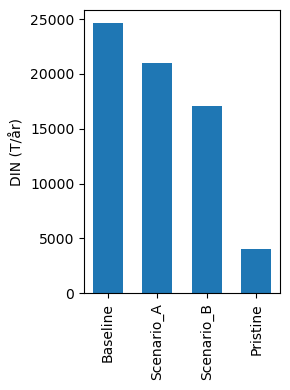

In [37]:
plt.figure(figsize=(3, 4))
ax = plt.gca()

# colors = ['grey', 'orange', 'red', 'green', 'green', 'green']
plt.bar(tot_of_df.index, tot_of_df['DIN'], width=0.6)#, color=colors)
plt.ylabel('DIN (T/år)')

# Rename x-axis labels
# new_labels = ['Dagens tilstand', '100% sommer DIN', 'Optimistisk-realistisk', '25% DIN', '50% DIN', '75% DIN', '100% DIN']  # Provide your own labels
# ax.set_xticklabels(new_labels)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

# fpath = os.path.join(out_folder_figs, 'barchart_total-annual-din_whole-of800-domain.png')
# plt.savefig(fpath)

plt.show()

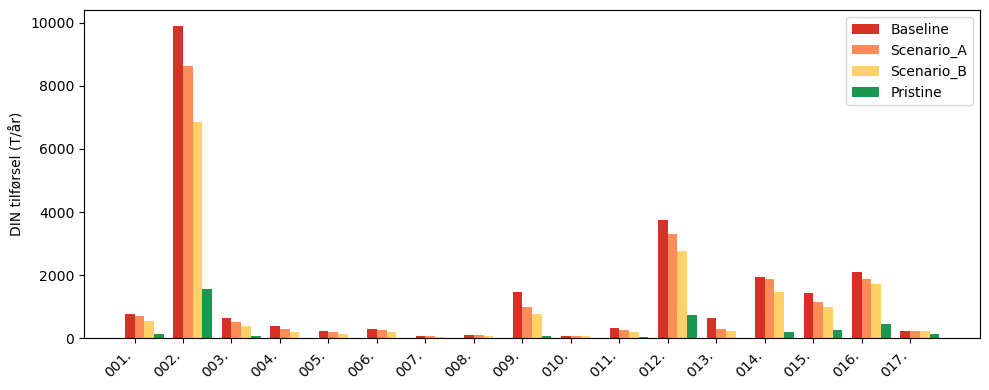

In [38]:
# Plot scenarios as bar chart, split by Vassdragsområder

color_dict = {
    'Baseline': '#D73027',
    'Scenario_A': '#FC8D59',
    'Scenario_B': '#FFD166',
    'Pristine': '#1A9850'
}

df = tot_annual_av_dict['Baseline'].copy()

# Drop the two Swedish rivs
df = df.loc[:'017.', :]

# locations = list(df.index.map(vass_num_to_name))
locations = df.index

# Set the width of the bars
bar_width = 0.2

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10,4))

# For each scenario, plot a bar for each index value
for i, (scenario, df) in enumerate(tot_annual_av_dict.items()):

    # Drop the two Swedish rivs
    df = df.loc[:'017.', :]

    # Get color from dictionary, default to gray if not found
    color = color_dict.get(scenario, 'gray')

    # new_label = translate_scenario_mapping.get(scenario, scenario)
    ax.bar(
        np.arange(len(df.index)) + i * bar_width,
        df['DIN'],
        bar_width,
        color=color,
        label=scenario
    )#, label=new_label)

# Set the x-ticks to be the index values
ax.set_xticks(np.arange(len(locations)) + bar_width / 2)
ax.set_xticklabels(locations)

# Tidy
ax.set_ylabel('DIN tilførsel (T/år)')

plt.xticks(rotation=45, ha='right')

# ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()

fpath = os.path.join(out_folder_scenario_figs, 'barchart_total-annual-din_by-vassområde.png')
plt.savefig(fpath)

plt.show()

In [39]:
# For making individual bar charts that were then placed manually on the Oslofjord map

# bar_width = 0.9
# label_dict = {'baseline': 'B',
#               'realistic': 'R'}

# scen_li = ['baseline', 'realistic']
# ymax_big = tot_annual_av_dict['baseline']['DIN'].max() / 1000
# ymax_small = 2000.0 / 1000

# for vassom in df.index:
#     fig, ax = plt.subplots(figsize=(1, 1.5))

#     # Set y-axis scale
#     if vassom in ['002.', '012.']:
#         ax.set_ylim(0, ymax_big)
#     else:
#         ax.set_ylim(0, ymax_small)

#     for i, scenario in enumerate(scen_li):
#         df = tot_annual_av_dict[scenario].copy()

#         ax.bar(i, df.loc[vassom, 'DIN'] / 1000, bar_width, label=label_dict[scenario])

#     # Set the x-ticks to be the scenarios
#     pc_reduction = annual_av_res_df.loc[vassom, 'pc_DIN_reduction']
#     t_din_removed = annual_av_res_df.loc[vassom, 'pc_DIN_reduction']
#     ax.set_xticks(range(len(scen_li)))
#     # ax.set_xticklabels([label_dict[scenario] for scenario in scen_li])
#     ax.set_xticklabels([label_dict[scenario] + ('\n(' + str(pc_reduction) + '%)' if scenario == 'realistic' else '') for scenario in scen_li], size=14)

#     # Simplify plot
#     ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

#     ax.set_ylabel('T DIN/year', size=14)
#     ax.set_title(vass_num_to_name[vassom], size=16)

#     fpath = os.path.join(out_folder_scenario_figs, 'vassom_barcharts', 'barchart_tot-ann-av-din_%s.png' % vass_num_to_name[vassom])
#     plt.savefig(fpath, bbox_inches='tight')#, pad_inches=0.1)

# plt.show()

## Monthly

In [40]:
monthly_load_df['Vassom'].unique()
# drop = ['Strömsån', 'Strömsån']
# monthly_load_df = monthly_load_df.loc[~monthly_load_df['Vassom'].isin(drop), :]

KeyError: 'Vassom'

In [ ]:
order_by_contribution = True

monthly_load_df = tot_month_dict['Baseline'].copy()
# monthly_load_df['Vassdragsområde'] = monthly_load_df['Vassom'].map(vass_num_to_name)

monthly_load_df['Vassdragsområde'] = monthly_load_df.apply(
    lambda row: f"{row['Vassom']} {vass_num_to_name.get(row['Vassom'], 'Unknown')}",
    axis=1
)

# Drop Swedish rivers
drop = ['Strömsån', 'Enningdalsälv']
monthly_load_df = monthly_load_df.loc[~monthly_load_df['Vassom'].isin(drop), :]

# Plot stacked line chart
monthflux_unit_dict = {
    "Q": "10$^6$ m$^3$ måned$^{-1}$",
    "TotN": "10$^3$ kg måned$^{-1}$",
    "DIN": "10$^3$ kg måned$^{-1}$",
    "SS": "10$^3$ kg måned$^{-1}$",
    "TOC": "10$^3$ kg måned$^{-1}$",
    "TDP": "10$^3$ kg måned$^{-1}$",
    "TotP": "10$^3$ kg måned$^{-1}$"
}

# Compute ordering based on Q only
if order_by_contribution:
    q_order = (
        monthly_load_df.groupby("Vassdragsområde")["Q"]
        .sum()
        .sort_values(ascending=False)
        .index
    )

for var in ['Q'] + t3_var_li:

    pivot_df = monthly_load_df.pivot(index="date", columns="Vassdragsområde", values=var)

    # Order the columns of pivot_df according to total_contribution
    if order_by_contribution:
        pivot_df = pivot_df[q_order]  # Use Q-based ordering for all vars

    # Generate colors
    cmap = mpl.colormaps.get_cmap("tab20")  # 'tab20' is a colormap with 20 distinct colors
    colors = cmap(np.linspace(0, 1, len(pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 4.4))
    plt.stackplot(
        pivot_df.index,
        pivot_df.T,
        labels=pivot_df.columns,
        colors=colors,
    )
    xmin = mpl.dates.datestr2num(f'{start_year}-01-01')
    xmax = mpl.dates.datestr2num(f'{end_year+1}-01-01')
    plt.xlim([xmin, xmax])
    # plt.title("Monthly %s flux by vassdragsområde" % var)
    plt.ylabel(f"{var} ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    fpath = os.path.join(out_folder_scenario_figs, f'monthly_riv-and-isource_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Mean monthly mean fluxes

In [ ]:
# Monthly mean load over all years
monthly_load_df['date'] = pd.to_datetime(monthly_load_df['date'])
monthly_load_df['month'] = monthly_load_df['date'].dt.month

monthly_mean_load_df = monthly_load_df.groupby(['Vassdragsområde', 'month']).mean(numeric_only=True).reset_index()
monthly_mean_load_df

In [ ]:
# Plot
for var in ['Q'] + t3_var_li:

    pivot_df = monthly_mean_load_df.pivot(index="month", columns="Vassdragsområde", values=var)

    # Order the columns of pivot_df according to total_contribution
    ordered_pivot_df = pivot_df[q_order]  # Use Q-based ordering for all vars

    # Generate colors
    cmap = mpl.colormaps.get_cmap("tab20")  # colormap with 20 colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(10, 4.5))
    plt.stackplot(
        ordered_pivot_df.index,
        ordered_pivot_df.T,
        labels=ordered_pivot_df.columns,
        colors=colors,
    )
    plt.xlim([1, 12])
    plt.ylabel(f"{var} ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xlabel("Måned", fontsize=12)
    plt.xticks(fontsize=10)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    fpath = os.path.join(out_folder_scenario_figs, f'monthly_mean_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Boxplots of daily values

**N.B. y-axis limit set to 6 below for clarity; this truncates TotN values:**
- Up to 17.5 in Hølenelva
- Up to 7.3 in Aulielva

In [ ]:
conc_df = daily_conc_dict['Baseline'].copy()
conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Melt dataFrame to have rivers, dates, variable (column1 or column2), and value
df_melted = conc_df[['TotN', 'DIN', 'river_name', 'date']].melt(id_vars=['river_name', 'date'], var_name='variable', value_name='value')

# Create a boxplot
plt.figure(figsize=(10, 5))
box_plot = sns.boxplot(x='river_name', y='value', hue='variable', data=df_melted, fliersize=1, width=0.6, showfliers=True)

# Tidy up
box_plot.set_xlabel('')
box_plot.legend(title=None, framealpha=1)
plt.xticks(rotation=45, ha='right')
plt.ylim(ymin=0.1, ymax=6.5)
# plt.yscale('log')
plt.grid(axis='y')
ax = plt.gca()  # Get the current Axes instance
ax.set_axisbelow(True)  # Set gridlines to be below other graph elements

plt.ylabel('N konsentrasjon (mg/l)')
# plt.title('Boxplot of Concentrations by River')

plt.tight_layout()
fpath = os.path.join(out_folder_scenario_figs, f'daily_conc_boxplots_{start_year}-{end_year}.png')
plt.savefig(fpath)

plt.show()

In [ ]:
ymax = {
    "SS": 120,
    "TOC": 15,
    "TDP": 0.3
}

for var in ['SS', 'TOC', 'TDP']:

    conc_df = daily_conc_dict['Baseline'].copy()
    conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

    # Melt dataFrame to have rivers, dates, variable (column1 or column2), and value
    df_melted = conc_df[[var, 'river_name', 'date']].melt(id_vars=['river_name', 'date'], var_name='variable', value_name='value')

    # Create a boxplot
    plt.figure(figsize=(8, 5))
    box_plot = sns.boxplot(x='river_name', y='value', hue='variable', data=df_melted, fliersize=1, width=0.6, showfliers=True)

    # Tidy up
    box_plot.set_xlabel('')
    box_plot.legend(title=None, framealpha=1)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(ymin=0, ymax=ymax[var])
    # plt.yscale('log')
    plt.grid(axis='y')
    ax = plt.gca()  # Get the current Axes instance
    ax.set_axisbelow(True)  # Set gridlines to be below other graph elements

    plt.ylabel(f'{var} konsentrasjon (mg/l)')
    # plt.title('Boxplot of Concentrations by River')

    plt.tight_layout()
    fpath = os.path.join(out_folder_scenario_figs, f'daily_conc_boxplots_{start_year}-{end_year}_{var}.png')
    plt.savefig(fpath)

    plt.show()